# Tuning the resolution of the fine simulation
In light of the preliminary runs, this notebook will explore how the statistical properties of the flow depend on the spatial resolution. In particular, I will now vary the vertical and horizontal resolutions independently. The properties of interest are:
- Number of convective cells, and
- 99th percentile vertical velocity at $z=1/2$.

I keep the same Rayleigh number ($\mathrm{Ra} = 10^8$) but increase the aspect ratio to 8. Furthermore, I have rewritten the governing equations in terms of the normal temperature anomaly, which is measured relative to a constant value, and rescaled the variables so their magnitudes are closer to unity. The equations now read
$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$
with boundary conditions
$$
\begin{align*}
    \vec{u}(z=0) &= \vec{0}, & \qquad \vec{u}(z=1) &= \vec{0}, \\
    \theta(z=0) &= -\frac{1}{2}, & \qquad \theta(z=1) &= +\frac{1}{2}.
\end{align*}
$$

In [44]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
from IPython.display import Video

## Spin-up and simulation time
The next two subsections analyse a long high-resolution run with the following parameters:
- Aspect ratio 8
- $\mathrm{Ra} = 10^8$
- $\mathrm{Pr} = 1$
- 1024 horizontal modes
- 128 vertical modes
- Time step 20
- Simulation length $2 \times 10^6$ time units

An animation of the first half of the run is shown below.

In [261]:
Video('../data/dns_1024_128_longer/dns_1024_128_longer_s1.mp4')

### Spin-up time
We are interested in the steady-state 99th percentile velocity, so the initial transients must be discarded. The plot below shows the evolution of the histogram of $|w(z=1/2)|$ over time.

In [226]:
files = glob.glob('../data/dns_1024_128_longer/dns_1024_128_longer_s*.nc')
data = xr.open_mfdataset(files)

In [243]:
w_mid = data.w.interp(z=0.5)
lim = np.abs(w_mid).max()
w_bin_edges = np.linspace(0, lim, 200)
w_bin_centers = (w_bin_edges[:-1] + w_bin_edges[1:])/2

def hist(array):
    return array.groupby_bins(array, w_bin_edges).count().fillna(0)

t_bin_edges = np.linspace(0, w_mid.t[-1], 41)
t_bin_centers = (t_bin_edges[:-1] + t_bin_edges[1:])/2
w_mid_grouped = np.abs(w_mid).groupby_bins('t', t_bin_edges)
w_mid_hist = w_mid_grouped.map(hist)
w_mid_99 = w_mid_grouped.quantile(0.99, dim=['x', 't'])

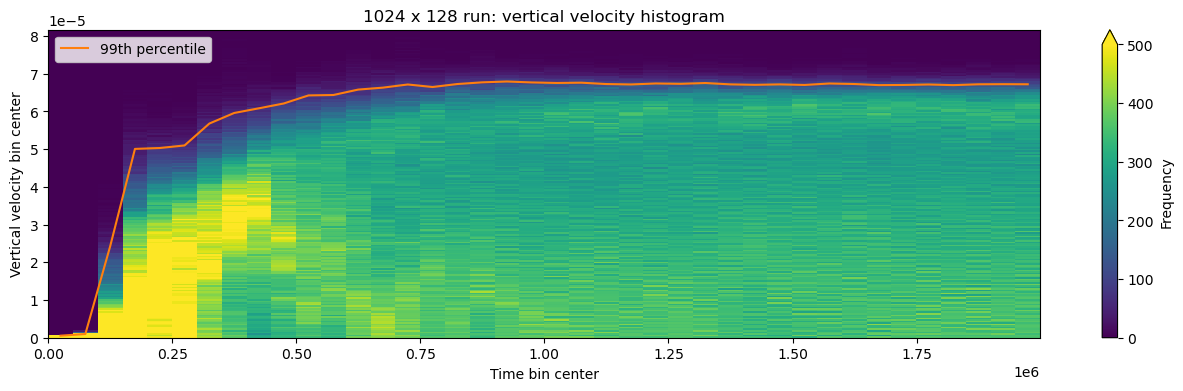

In [247]:
fig, ax = plt.subplots(figsize=(16,4))
mesh = ax.pcolormesh(t_bin_centers, w_bin_centers, w_mid_hist.T, vmax=500)
fig.colorbar(mesh, ax=ax, label='Frequency', extend='max')
ax.plot(t_bin_centers, w_mid_99, color='tab:orange', label='99th percentile')
ax.set(
    xlabel='Time bin center',
    ylabel='Vertical velocity bin center',
    title='1024 x 128 run: vertical velocity histogram'
)
ax.legend(loc='upper left')

It appears that the distribution reaches equilibrium after approximately 10^6 time units. This is confirmed by plotting the percentage deviation of the 99th percentile from its final value:

[Text(0.5, 0, 'Time bin center'),
 Text(0, 0.5, 'Percentage change in 99th percentile')]

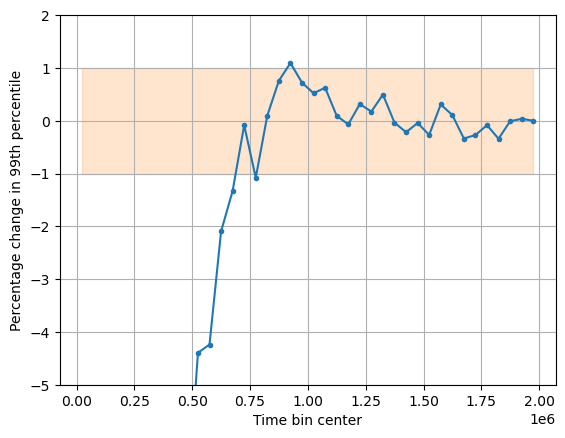

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(t_bin_centers, -1, 1, alpha=0.2, color='tab:orange')
ax.plot(t_bin_centers, (w_mid_99/w_mid_99[-1] - 1)*1e2, '.-')
ax.set_ylim(-5, 2)
ax.grid()
ax.set(xlabel='Time bin center', ylabel='Percentage change in 99th percentile')

If the estimates are to be accurate within 1%, then 10^6 time units of spin-up are required.

### Simulation time
The period of simulation after spin-up must also be long enough for the sample quantiles to be close to their true values. Below is a plot of the 99th percentile as a function of the time span over which it is calculated.

In [283]:
t_spinup = 1e6
end_times = w_mid.t[w_mid.t > t_spinup][::5]

def percentile_99(end_time):
    data = w_mid[(w_mid.t >= t_spinup) & (w_mid.t <= end_time)]
    return data.quantile(0.99)

percentiles = xr.apply_ufunc(percentile_99, end_times, vectorize=True)

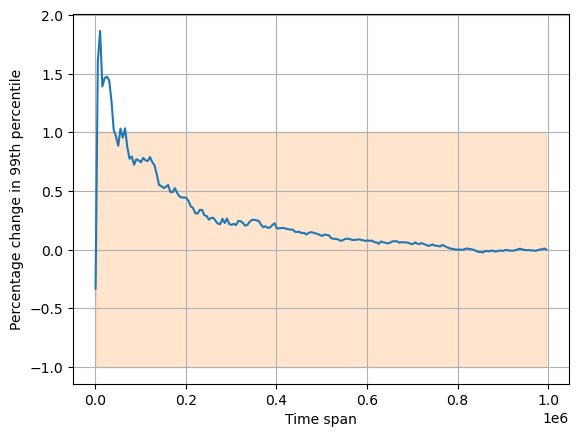

In [292]:
fig, ax = plt.subplots()
ax.plot(end_times - t_spinup, (percentiles/percentiles[-1] - 1)*1e2)
ax.set(xlabel='Time span', ylabel='Percentage change in 99th percentile')
ax.fill_between(end_times - t_spinup, -1, 1, color='tab:orange', alpha=0.2)
ax.grid()

If we again require accuracy within 1%, then the necessary time span is much less than the spin-up time: $10^5$ time units should suffice, but we will use $2\times 10^5$ to be safe.

## Model runs
We are now ready to run the model at each resolution. It would be unrealistic to keep the time step constant, so I will instead scale it in proportion to the spatial resolution by fixing the Courant number. That is, if the subscripts 1 and 2 denote two different runs,
$$
    \Delta t_1 \left( \frac{u_1}{\Delta x_1} + \frac{w_1}{\Delta z_1} \right)
    = \Delta t_2 \left( \frac{u_2}{\Delta x_2} + \frac{w_2}{\Delta z_2} \right).
$$
If we assume that the runs have similar velocities, and that the vertical and horizontal velocity scales are similar, this reduces to
$$
\begin{align*}
    \Delta t_2 &\approx \frac{1/\Delta x_1 + 1/\Delta z_1}{1/\Delta x_2 + 1/\Delta z_2} \\
    &\approx \frac{N_{x1}/\alpha + N_{z1}}{N_{x2}/\alpha + N_{z2}}
\end{align*}
$$
where $\alpha = 8$ is the aspect ratio. The table below shows the $(N_x, N_z)$ pairs that will be tested, and the corresponding time steps (to 3 significant figures).


<style>
    td {
      text-align: center;
    }
</style>

<table>
<tbody>
  <tr>
    <td></td>
    <td></td>
    <td colspan="5">Nx</td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>256</td>
    <td>384</td>
    <td>512</td>
    <td>768</td>
    <td>1024</td>
  </tr>
  <tr>
    <td rowspan="5">Nz</td>
    <td>32</td>
    <td>80.0</td>
    <td>-</td>
    <td>53.3</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>48</td>
    <td>-</td>
    <td>53.3</td>
    <td>-</td>
    <td>35.6</td>
    <td>-</td>
  </tr>
  <tr>
    <td>64</td>
    <td>53.3</td>
    <td>-</td>
    <td>40.0</td>
    <td>-</td>
    <td>26.7</td>
  </tr>
  <tr>
    <td>96</td>
    <td>-</td>
    <td>35.6</td>
    <td>-</td>
    <td>26.7</td>
    <td>-</td>
  </tr>
  <tr>
    <td>128</td>
    <td>-</td>
    <td>-</td>
    <td>26.7</td>
    <td>-</td>
    <td>20.0</td>
  </tr>
</tbody>
</table>

### 99th percentile velocity

In [72]:
def w_99(nx, nz):
    files = glob.glob(
        f'../data/restest_{nx:d}_{nz:d}/restest_{nx:d}_{nz:d}_s*.nc')
    if len(files) == 0:
        return np.nan
    data = xr.open_mfdataset(files)
    w_sample = data.w[data.t >= 1e6].interp(z=0.5)
    return np.abs(w_sample).quantile(0.99)

nx = [256, 384, 512, 768, 1024]
nz = [32, 48, 64, 96, 128]
nx = xr.DataArray(nx, coords=[nx], dims=['nx'])
nz = xr.DataArray(nz, coords=[nz], dims=['nz'])

percentiles = xr.apply_ufunc(w_99, nx, nz, vectorize=True)

[Text(0.5, 0, '$N_x$'), Text(0, 0.5, '$N_z$')]

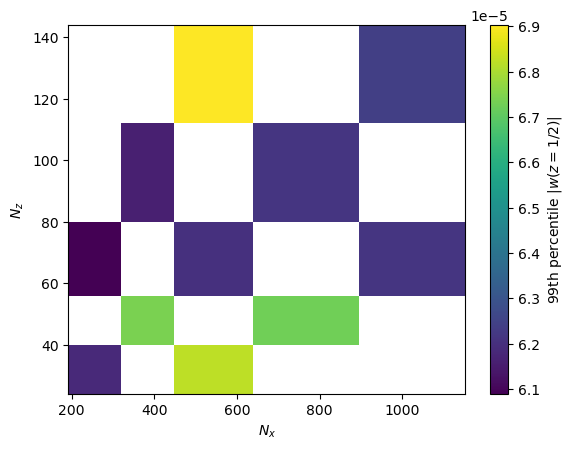

In [84]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(percentiles.nx, percentiles.nz, percentiles.T)
fig.colorbar(mesh, ax=ax, label='99th percentile $|w(z=1/2)|$')
ax.set(xlabel='$N_x$', ylabel='$N_z$')

^ annotate this with numbers?

### Number of convective cells

In [74]:
def plot_theta(nx, nz, ax):
    files = glob.glob(
        f'../data/restest_{nx:d}_{nz:d}/restest_{nx:d}_{nz:d}_s*.nc')
    data = xr.open_mfdataset(files)

    ax.pcolormesh(data.x, data.z, data.theta.isel(t=-1).T, cmap='RdBu_r')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'{nx:d} x {nz:d}')

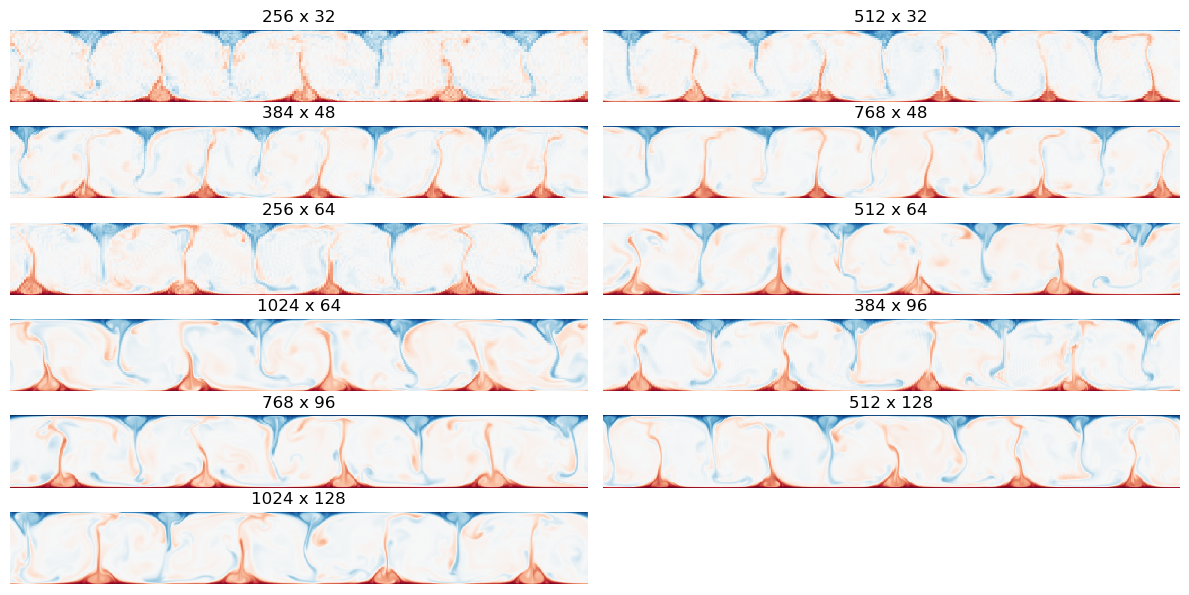

In [77]:
nx = [256, 512, 384, 768, 256, 512, 1024, 384, 768, 512, 1024]
nz = [32, 32, 48, 48, 64, 64, 64, 96, 96, 128, 128]
fig, axes = plt.subplots(6, 2, figsize=(12, 6))
for i in range(11):
    plot_theta(nx[i], nz[i], axes.flat[i])
axes[5, 1].axis('off')
fig.tight_layout()

In [78]:
# enter results as a (Nx, Nz, number) tuple
n_cells = {
    (256, 32): 4,
    (512, 32): 5,
    (384, 48): 5,
    (768, 48): 5,
    (256, 64): 4,
    (512, 64): 4,
    (1024, 64): 4,
    (384, 96): 4,
    (768, 96): 4,
    (512, 128): 5,
    (1024, 128): 4,
}
nx = [256, 384, 512, 768, 1024]
nz = [32, 48, 64, 96, 128]
nx = xr.DataArray(nx, coords=[nx], dims=['nx'])
nz = xr.DataArray(nz, coords=[nz], dims=['nz'])
def get_n_cells(nx, nz):
    if (nx, nz) in n_cells.keys():
        return float(n_cells[(nx, nz)])
    else:
        return np.nan
n_cells = xr.apply_ufunc(get_n_cells, nx, nz, vectorize=True)

[Text(0.5, 0, '$N_x$'), Text(0, 0.5, '$N_z$')]

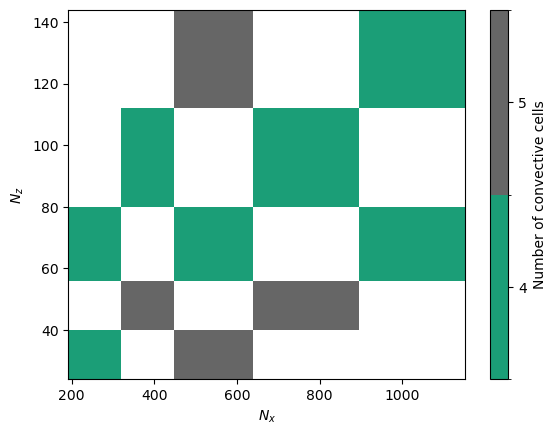

In [83]:
cmap = mpl.cm.Dark2
bounds = np.arange(n_cells.min() - 0.5, n_cells.max() + 1.5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
mesh = ax.pcolormesh(n_cells.nx, n_cells.nz, n_cells.T, norm=norm, cmap=cmap)
cbar = fig.colorbar(mesh, ax=ax, label='Number of convective cells')
cbar.ax.set_yticks(np.arange(n_cells.min(), n_cells.max() + 1))
ax.set(xlabel='$N_x$', ylabel='$N_z$')